# Общее описание проекта

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.\
Шаги для выбора локации обычно такие:\
В избранном регионе собирают характеристики для скважин: качество нефти и объём её запасов;\
Строят модель для предсказания объёма запасов в новых скважинах;\
Выбирают скважины с самыми высокими оценками значений;\
Определяют регион с максимальной суммарной прибылью отобранных скважин.\
Вам предоставлены пробы нефти в трёх регионах. Характеристики для каждой скважины в регионе уже известны. Постройте модель для определения региона, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой Bootstrap.

**Описание данных:**

Данные геологоразведки трёх регионов находятся в файлах:\ 
/datasets/geo_data_0.csv.\
/datasets/geo_data_1.csv.\
/datasets/geo_data_2.csv.\
id — уникальный идентификатор скважины;\
f0, f1, f2 — три признака точек (неважно, что они означают, но сами признаки значимы);\
product — объём запасов в скважине (тыс. баррелей).

**Условия задачи:**\
Для обучения модели подходит только линейная регрессия (остальные — недостаточно предсказуемые).\
При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.\
Бюджет на разработку скважин в регионе — 10 млрд рублей.\
При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.\
После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.
Данные синтетические: детали контрактов и характеристики месторождений не разглашаются.

# Импорт библиотек

In [1]:
import pandas as pd
import numpy as np
#Plot
import matplotlib.pyplot as plt
import seaborn as sns
#sclearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import accuracy_score, r2_score, mean_absolute_error, mean_squared_error
from sklearn.metrics import make_scorer
from sklearn.linear_model import LinearRegression

# Загрузка данных

In [2]:
try:
    geo_data_0 = pd.read_csv(r"C:\Users\bondarev\Documents\DS study\data\sprint_13_oil_wells\geo_data_0.csv")
    geo_data_1 = pd.read_csv(r"C:\Users\bondarev\Documents\DS study\data\sprint_13_oil_wells\geo_data_1.csv")
    geo_data_2 = pd.read_csv(r"C:\Users\bondarev\Documents\DS study\data\sprint_13_oil_wells\geo_data_2.csv")
except:
    geo_data_0 = pd.read_csv("/datasets/geo_data_0.csv")
    geo_data_1 = pd.read_csv("/datasets/geo_data_1.csv")
    geo_data_2 = pd.read_csv("/datasets/geo_data_2.csv")

## Предварительный общий обзор

Локация №0:

In [3]:
geo_data_0.head()

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


In [4]:
geo_data_0.shape

(100000, 5)

Локация №1:

In [5]:
geo_data_1.head()

,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


In [6]:
geo_data_1.shape

(100000, 5)

Локация №2:

In [7]:
geo_data_2.head()

,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


In [8]:
geo_data_2.shape

(100000, 5)

**Вывод:**\
Выполнен предварительный обзор данных. Данные соответствуют описанию.

# Обзор данных

In [9]:
# функция для обзора данных
def data_overview(df, discret_values=20):
    import pandas as pd
    import matplotlib.pyplot as plt
    import seaborn as sns

    # 1. Выводим первые 5 строк
    print("Первых 5 строк данных:")
    display(df.head())

    # 2. Информация о DataFrame
    print("\nИнформация о DataFrame:")
    df.info()

    # 3. Количество пропусков
    missing_data = df.isnull().sum()
    missing_percent = (missing_data / len(df)) * 100
    missing_df = pd.DataFrame({
        'Пропуски (шт)': missing_data,
        'Пропуски (%)': missing_percent
    })
    missing_df = missing_df[missing_df['Пропуски (шт)'] > 0]
    print("\nКоличество пропусков (в шт и в %):")
    display(missing_df.style.background_gradient(cmap="YlOrRd"))

    # 4. Количество явных дубликатов
    duplicates_count = df.duplicated().sum()
    print(f"\nКоличество явных дубликатов: {duplicates_count}")

    # 5. Уникальные значения по нечисловым полям
    non_numeric_cols = df.select_dtypes(exclude=["number", "datetime"])
    print("\nУникальные значения по нечисловым полям:")
    for col in non_numeric_cols.columns:
        unique_values = non_numeric_cols[col].unique()
        print(f"{col}: {unique_values[:10]}{'...' if len(unique_values) > 10 else ''}")
        print('')

    # 6. Минимальное и максимальное значение для полей с датами
    date_cols = df.select_dtypes(include=["datetime"])
    if not date_cols.empty:
        print("\nМинимальные и максимальные значения для полей с датами:")
        for col in date_cols.columns:
            print(f"{col}: min = {df[col].min()}, max = {df[col].max()}")

    # 7. Описательная статистика, исключая поля с 'id'
    numeric_cols = df.select_dtypes(include=["number"]).columns
    numeric_cols_no_id = [col for col in numeric_cols if 'id' not in col.lower()]
    if numeric_cols_no_id:
        print("\nОписательная статистика для числовых полей (без 'id'):")
        display(df[numeric_cols_no_id].describe())
    else:
        print("\nНет числовых полей без 'id' для описательной статистики.")

    # 8. Определение типа признака и построение графиков
    if numeric_cols_no_id:
        for col in numeric_cols_no_id:
            unique_values = df[col].nunique()
            if unique_values <= discret_values:  # Дискретный признак
                print(f"\nДискретный признак: {col}")
                fig, axes = plt.subplots(1, 2, figsize=(12, 5))
                sns.countplot(data=df, x=col, order=df[col].value_counts().index,  ax=axes[0])
                axes[0].set_title(f"Столбчатая диаграмма: {col}")
                axes[0].tick_params(axis='x', rotation=45)
                sns.boxplot(x=df[col], ax=axes[1])
                axes[1].set_title(f"Boxplot: {col}")
                plt.tight_layout()
                plt.show()
            else:  # Непрерывный признак
                print(f"\nНепрерывный признак: {col}")
                fig, axes = plt.subplots(1, 2, figsize=(12, 5))
                sns.histplot(df[col].dropna(), ax=axes[0], kde=True)
                axes[0].set_title(f"Гистограмма: {col}")
                sns.boxplot(x=df[col], ax=axes[1])
                axes[1].set_title(f"Boxplot: {col}")
                plt.tight_layout()
                plt.show()
    else:
        print("\nНет числовых полей без 'id' для построения графиков.")

## Локация №0

Первых 5 строк данных:


,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647



Информация о DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB

Количество пропусков (в шт и в %):


,Пропуски (шт),Пропуски (%)



Количество явных дубликатов: 0

Уникальные значения по нечисловым полям:
id: ['txEyH' '2acmU' '409Wp' 'iJLyR' 'Xdl7t' 'wX4Hy' 'tL6pL' 'BYPU6' 'j9Oui'
 'OLuZU']...


Описательная статистика для числовых полей (без 'id'):


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.500419,0.250143,2.502647,92.500000
std,0.871832,0.504433,3.248248,44.288691
min,-1.408605,-0.848218,-12.088328,0.000000
25%,-0.072580,-0.200881,0.287748,56.497507
50%,0.502360,0.250252,2.515969,91.849972
75%,1.073581,0.700646,4.715088,128.564089
max,2.362331,1.343769,16.003790,185.364347



Непрерывный признак: f0


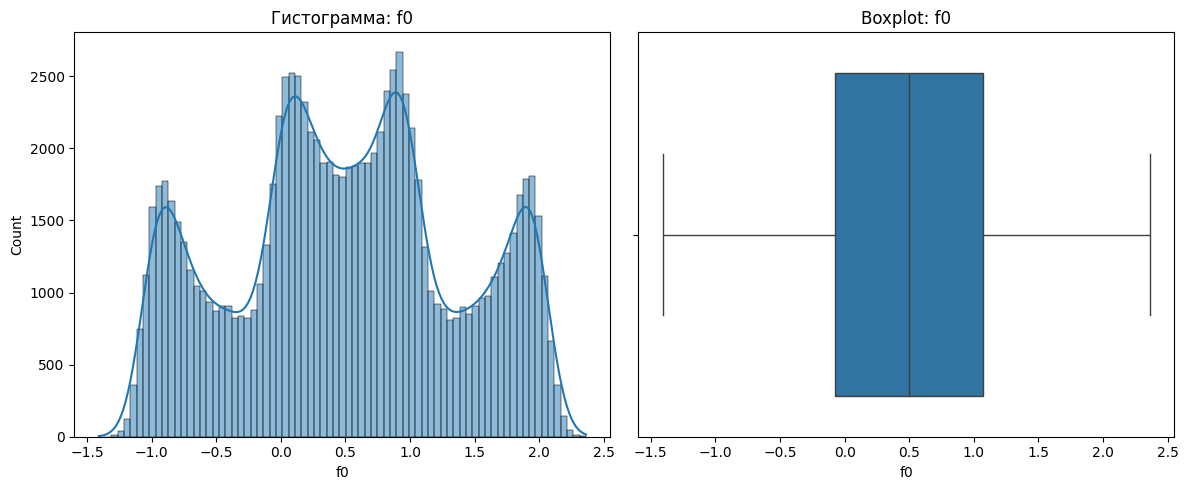


Непрерывный признак: f1


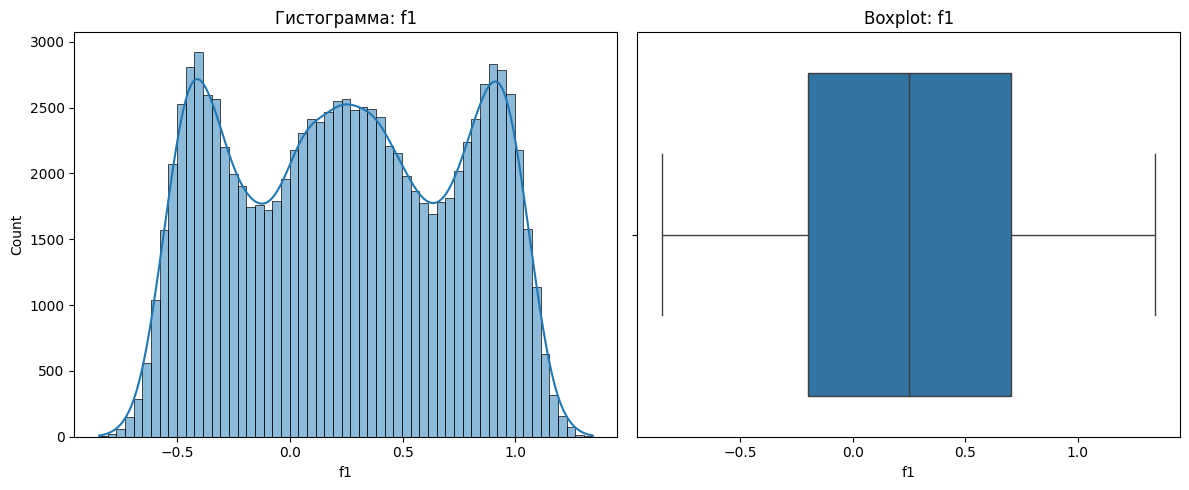


Непрерывный признак: f2


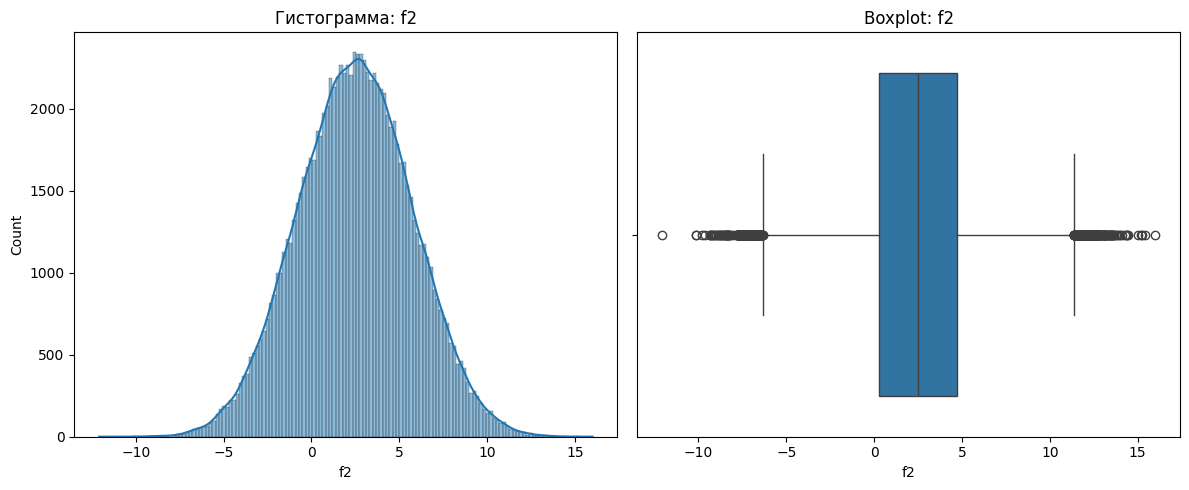


Непрерывный признак: product


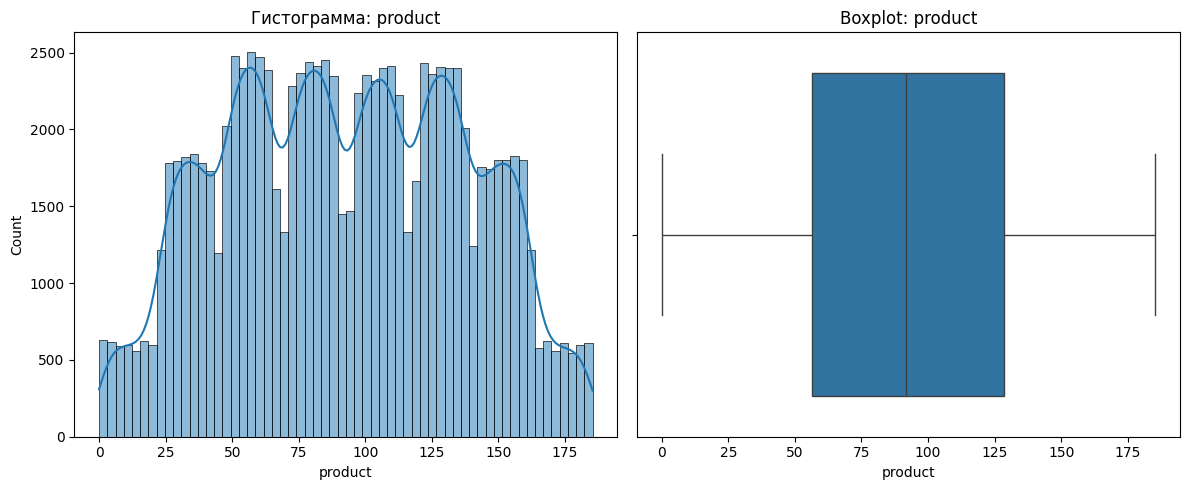

In [10]:
data_overview(geo_data_0)

**Вывод:**\
Визуально видимых ошибок в заполнении данных не обнаружено. Преобразование типов данных не требуется.\
Пропуски не обнаружены.\
Явные и неявные дубликаты не обнаружены.

## Локация №1

Первых 5 строк данных:


,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305



Информация о DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB

Количество пропусков (в шт и в %):


,Пропуски (шт),Пропуски (%)



Количество явных дубликатов: 0

Уникальные значения по нечисловым полям:
id: ['kBEdx' '62mP7' 'vyE1P' 'KcrkZ' 'AHL4O' 'HHckp' 'h5Ujo' 'muH9x' 'YiRkx'
 'jG6Gi']...


Описательная статистика для числовых полей (без 'id'):


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.141296,-4.796579,2.494541,68.825000
std,8.965932,5.119872,1.703572,45.944423
min,-31.609576,-26.358598,-0.018144,0.000000
25%,-6.298551,-8.267985,1.000021,26.953261
50%,1.153055,-4.813172,2.011479,57.085625
75%,8.621015,-1.332816,3.999904,107.813044
max,29.421755,18.734063,5.019721,137.945408



Непрерывный признак: f0


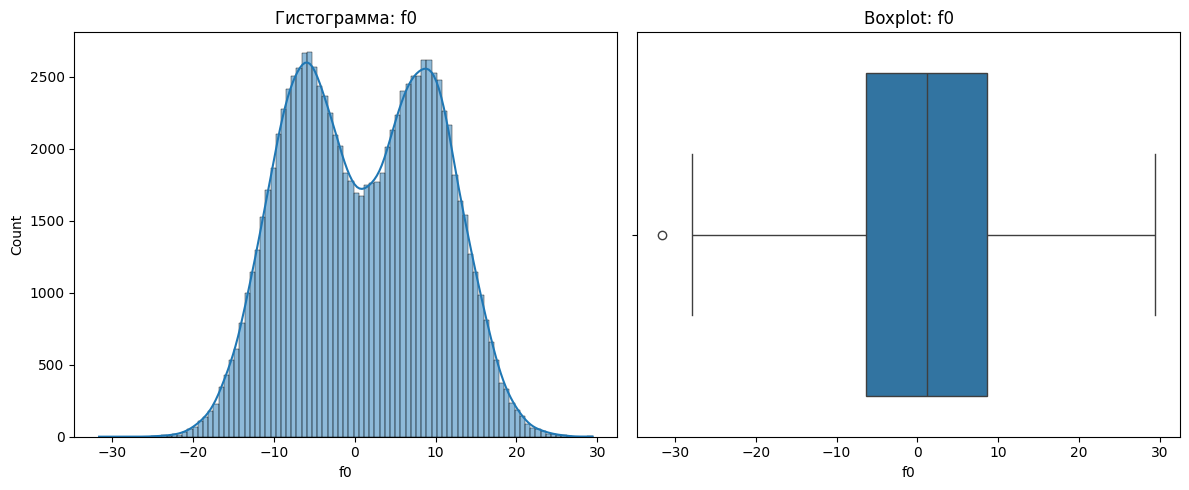


Непрерывный признак: f1


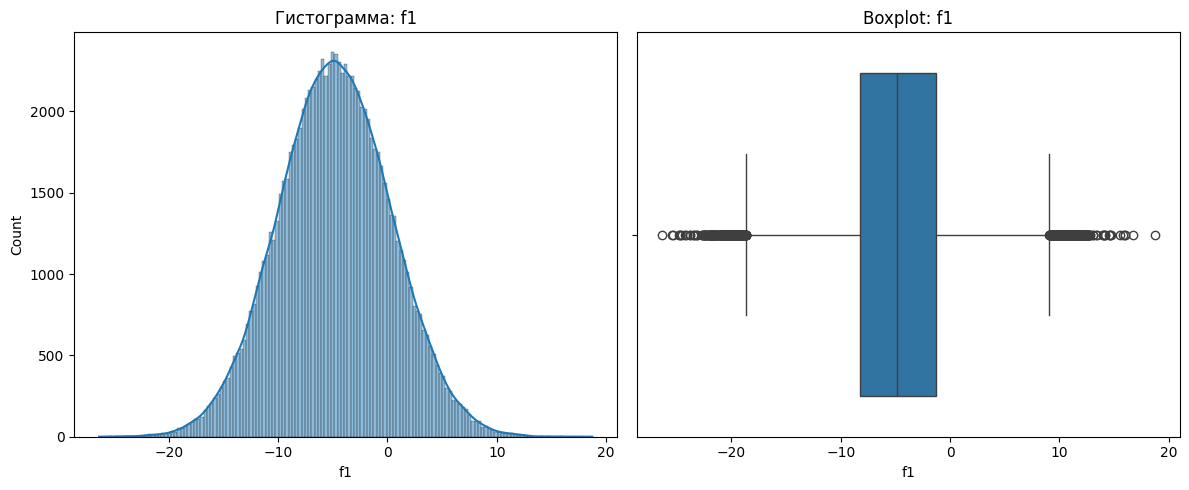


Непрерывный признак: f2


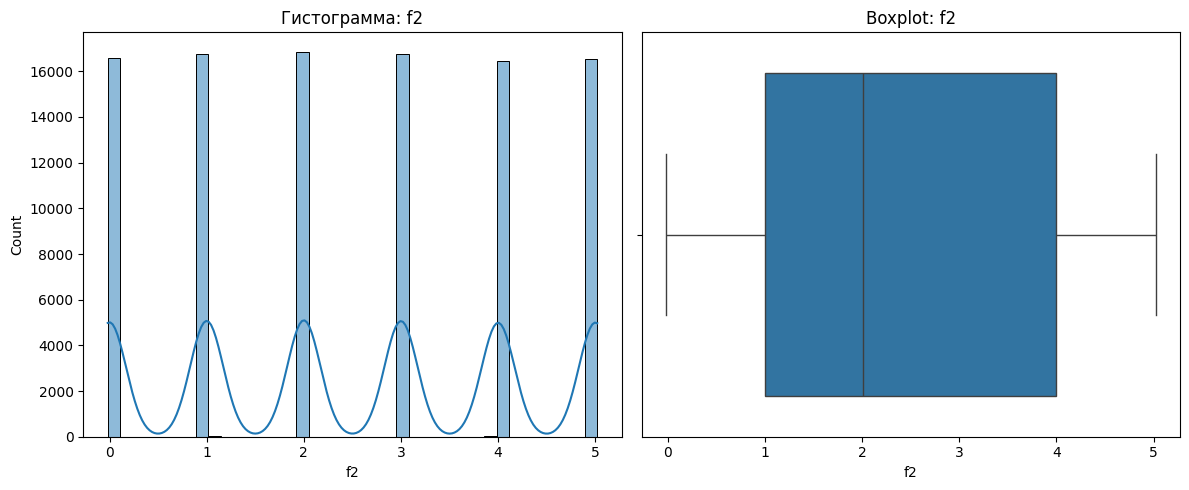


Дискретный признак: product


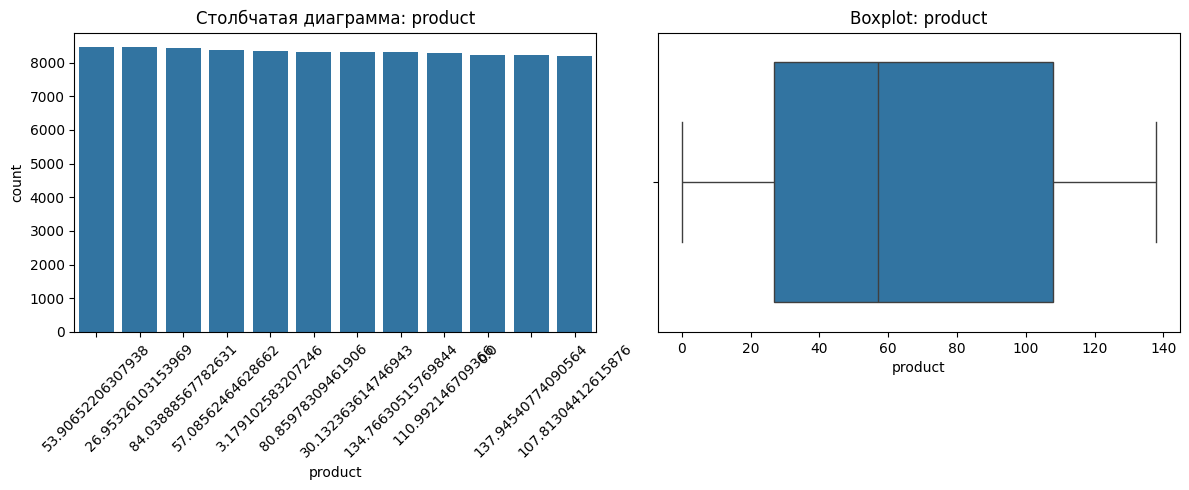

In [11]:
data_overview(geo_data_1)

In [12]:
geo_data_1.duplicated(subset='id').sum()

4

**Вывод:**\
Визуально видимых ошибок в заполнении данных не обнаружено. Преобразование типов данных не требуется.\
Пропуски не обнаружены.\
Явные и неявные дубликаты не обнаружены.

## Локация №2

Первых 5 строк данных:


,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746



Информация о DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB

Количество пропусков (в шт и в %):


,Пропуски (шт),Пропуски (%)



Количество явных дубликатов: 0

Уникальные значения по нечисловым полям:
id: ['fwXo0' 'WJtFt' 'ovLUW' 'q6cA6' 'WPMUX' 'LzZXx' 'WBHRv' 'XO8fn' 'ybmQ5'
 'OilcN']...


Описательная статистика для числовых полей (без 'id'):


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.002023,-0.002081,2.495128,95.000000
std,1.732045,1.730417,3.473445,44.749921
min,-8.760004,-7.084020,-11.970335,0.000000
25%,-1.162288,-1.174820,0.130359,59.450441
50%,0.009424,-0.009482,2.484236,94.925613
75%,1.158535,1.163678,4.858794,130.595027
max,7.238262,7.844801,16.739402,190.029838



Непрерывный признак: f0


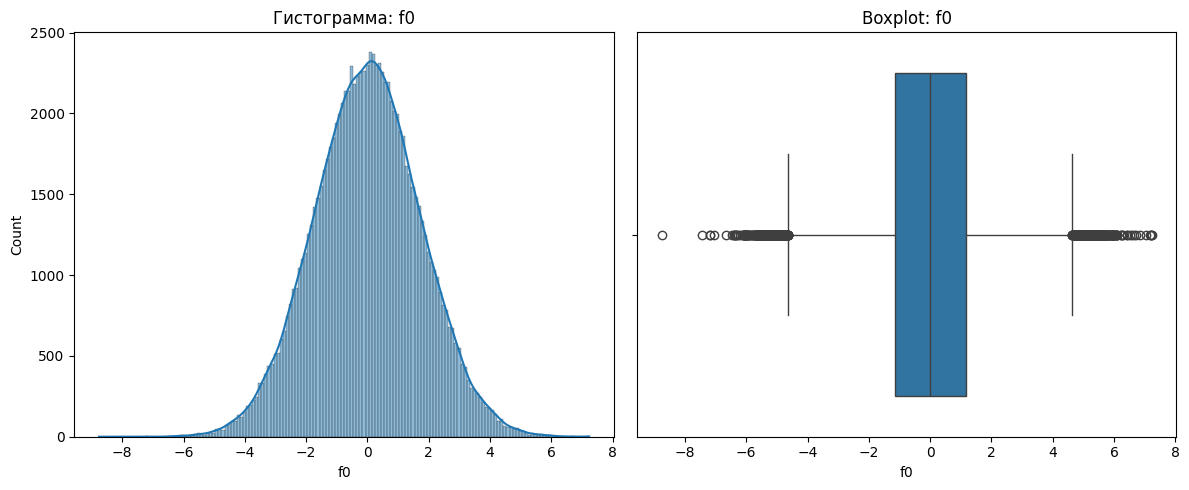


Непрерывный признак: f1


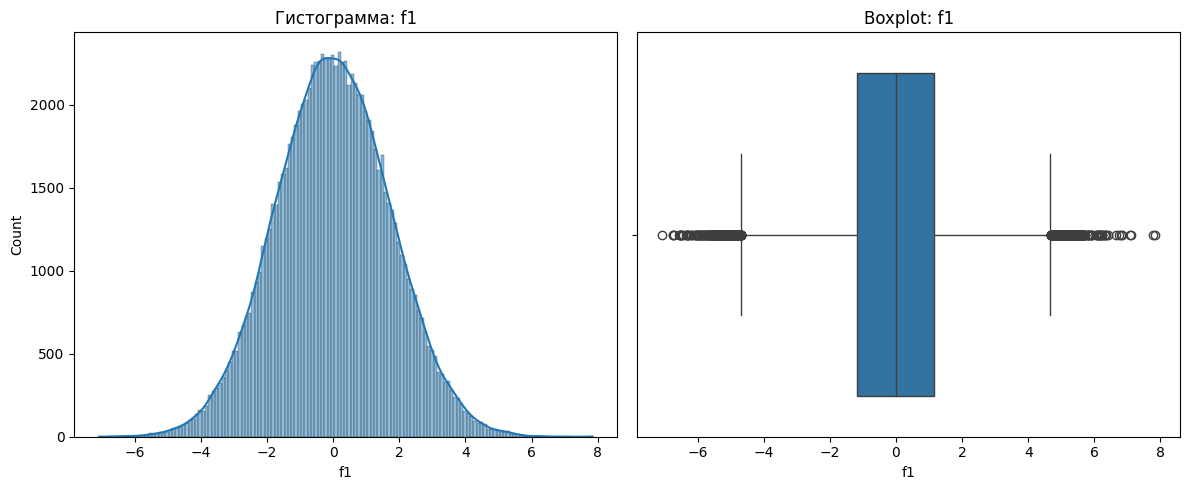


Непрерывный признак: f2


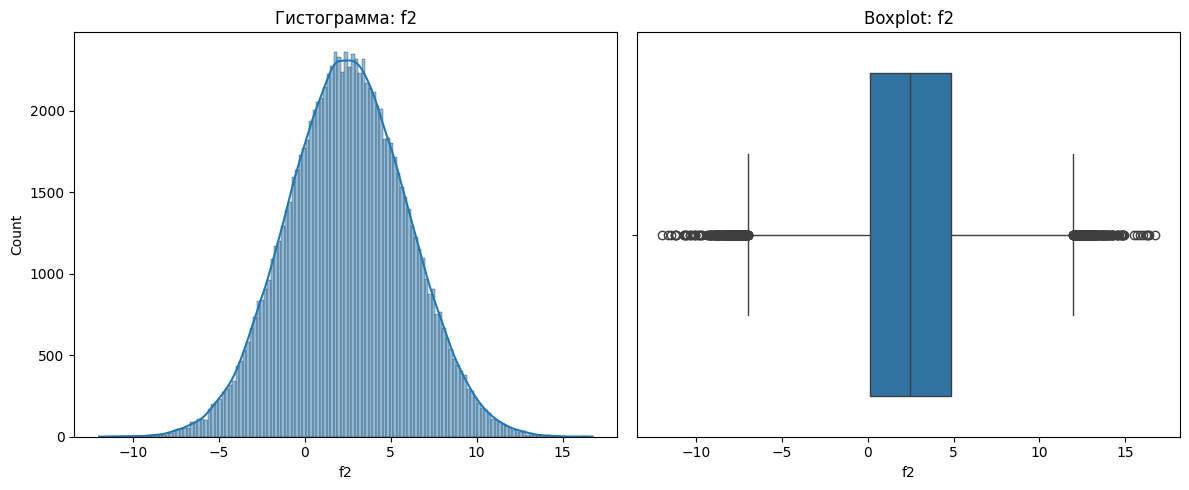


Непрерывный признак: product


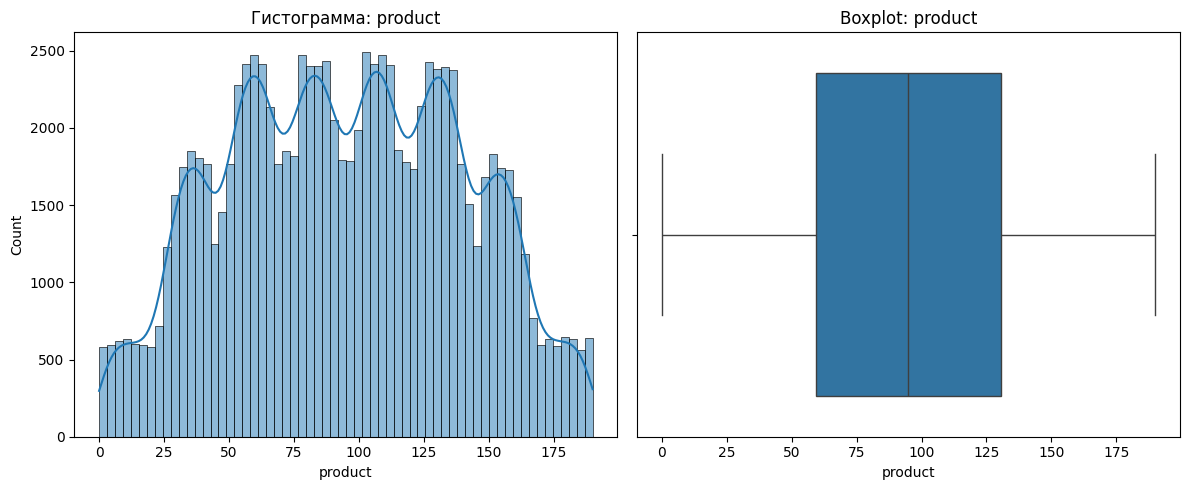

In [13]:
data_overview(geo_data_2)

**Вывод:**\
Визуально видимых ошибок в заполнении данных не обнаружено. Преобразование типов данных не требуется.\
Пропуски не обнраужены.\
Явные и неявные дубликаты не обнаружены.

## Общий вывод

*Локация №0:*\
Визуально видимых ошибок в заполнении данных не обнаружено. Преобразование типов данных не требуется.\
Пропуски не обнраужены.\
Явные и неявные дубликаты не обнаружены.

*Локация №1:*\
Визуально видимых ошибок в заполнении данных не обнаружено. Преобразование типов данных не требуется.\
Пропуски не обнраужены.\
Явные и неявные дубликаты не обнаружены.

*Локация №2:*\
Визуально видимых ошибок в заполнении данных не обнаружено. Преобразование типов данных не требуется.\
Пропуски не обнраужены.\
Явные и неявные дубликаты не обнаружены.

# Предобработка данных

Не требуется

# Исследовательский анализ данных

In [14]:
def plot_eda(df, hist_bins=30, discret_values=20):
    import matplotlib.pyplot as plt
    import seaborn as sns

    # Исключаем столбцы, содержащие 'id'
    filtered_df = df[[col for col in df.columns if 'id' not in col.lower()]]
    
    # Числовые и категориальные столбцы
    numeric_columns = filtered_df.select_dtypes(include=['number']).columns
    categorical_columns = filtered_df.select_dtypes(exclude=['number']).columns

    # Числовые поля
    for col in numeric_columns:
        unique_values = filtered_df[col].nunique()
        if unique_values <= discret_values:  # Дискретный признак
            print(f"\nДискретный признак: {col}")
            fig, axes = plt.subplots(1, 2, figsize=(12, 5))
            sns.countplot(data=filtered_df, x=col, order=filtered_df[col].value_counts().index, ax=axes[0])
            axes[0].set_title(f"Столбчатая диаграмма: {col}")
            axes[0].tick_params(axis='x', rotation=45)
            sns.boxplot(x=filtered_df[col], ax=axes[1], color='orange')
            axes[1].set_title(f"Boxplot: {col}")
            plt.tight_layout()
            plt.show()
        else:  # Непрерывный признак
            print(f"\nНепрерывный признак: {col}")
            plt.figure(figsize=(8, 4))
            # Гистограмма
            plt.subplot(1, 2, 1)
            sns.histplot(filtered_df[col], kde=True, bins=hist_bins, color='blue')
            plt.title(f'Гистограмма: {col}')
            plt.xlabel(col)
            plt.ylabel('Частота')
            
            # Боксплот
            plt.subplot(1, 2, 2)
            sns.boxplot(x=filtered_df[col], color='orange')
            plt.title(f'Boxplot: {col}')
            plt.xlabel(col)
            plt.tight_layout()
            plt.show()

    # Категориальные поля
    for col in categorical_columns:
        # Подсчёт уникальных значений в каждой категории
        category_counts = filtered_df[col].value_counts().reset_index()
        category_counts.columns = [col, 'count']
        
        # Построение столбчатой и круговой диаграммы рядом
        fig, axes = plt.subplots(1, 2, figsize=(12, 6))
        
        # Столбчатая диаграмма
        sns.barplot(data=category_counts, x=col, y='count', palette='viridis', ax=axes[0])
        axes[0].set_title(f'Количество записей для каждой категории в {col}')
        axes[0].set_xlabel(col)
        axes[0].set_ylabel('Количество записей')
        axes[0].tick_params(axis='x', rotation=45)
        
        # Круговая диаграмма
        category_counts.set_index(col).plot.pie(
            y='count', autopct='%1.1f%%', legend=False, colors=sns.color_palette('viridis', len(category_counts)), ax=axes[1]
        )
        axes[1].set_title(f'Распределение категорий в {col}')
        axes[1].set_ylabel('')
        
        plt.tight_layout()
        plt.show()

## Локация №0


Непрерывный признак: f0


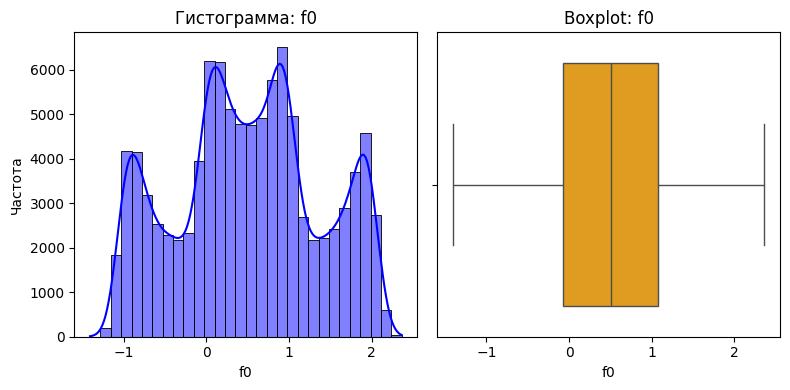


Непрерывный признак: f1


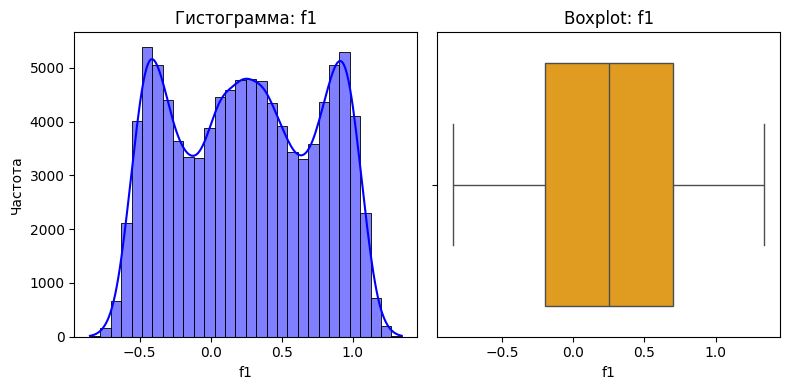


Непрерывный признак: f2


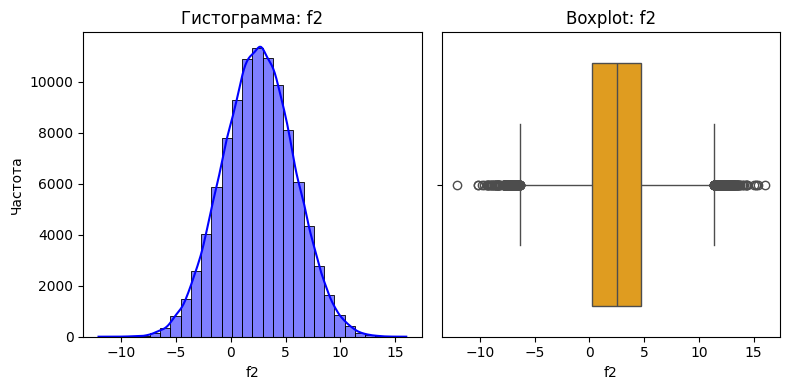


Непрерывный признак: product


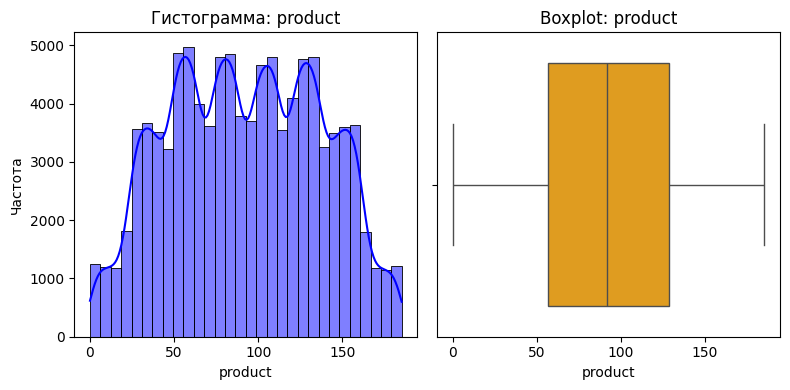

In [15]:
#построим гисторграммы и боксплот для всех числовых полей и столбчатую диаграмму для всех категориальных
plot_eda(geo_data_0)

In [16]:
# вывдем статистическую информацию по числовым полям
geo_data_0.describe()

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.500419,0.250143,2.502647,92.500000
std,0.871832,0.504433,3.248248,44.288691
min,-1.408605,-0.848218,-12.088328,0.000000
25%,-0.072580,-0.200881,0.287748,56.497507
50%,0.502360,0.250252,2.515969,91.849972
75%,1.073581,0.700646,4.715088,128.564089
max,2.362331,1.343769,16.003790,185.364347


Вывод:\
Признак f0 распределен ненормально, медиана равна 0.50\
Признак f1 распределен ненормально, медиана равна 0.25\
Признак f2 распределен нормально, медиана равна 2.51\
Параметр product распределен ненормально, медиана равна 91.85

## Локация №1


Непрерывный признак: f0


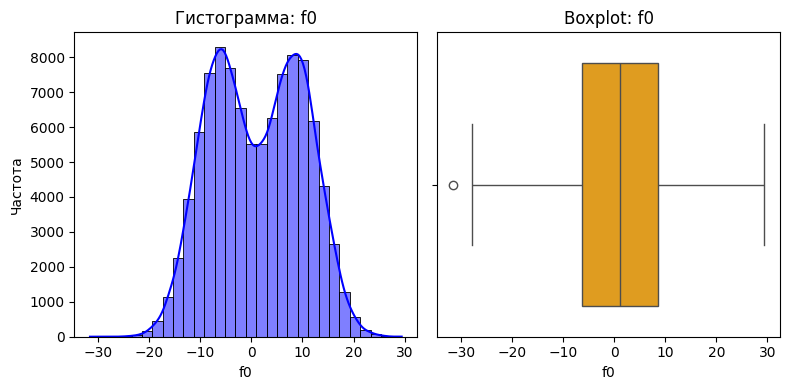


Непрерывный признак: f1


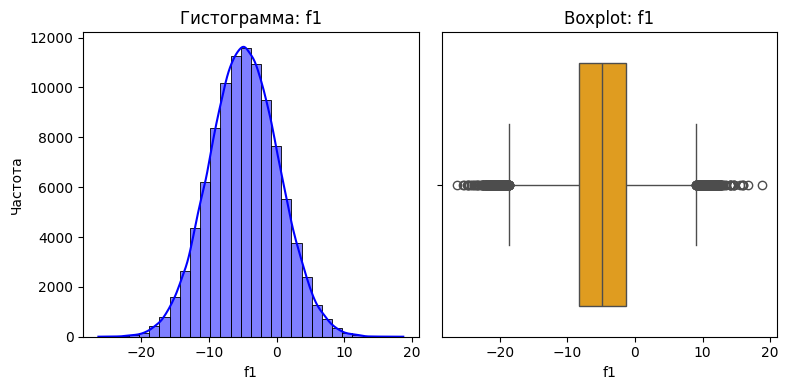


Непрерывный признак: f2


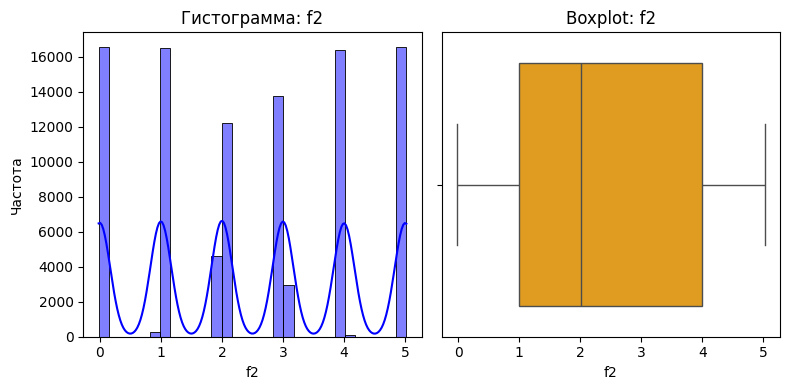


Дискретный признак: product


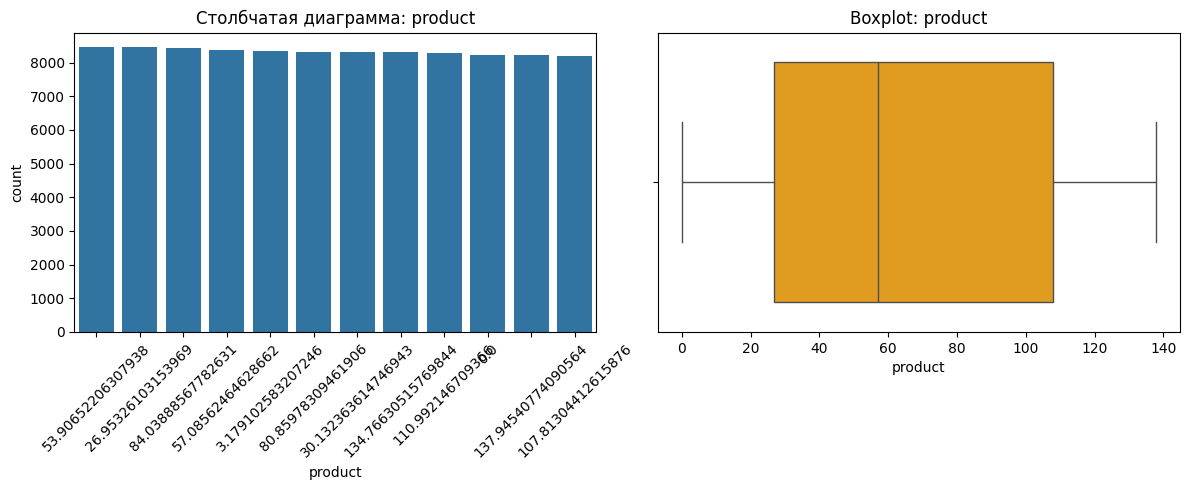

In [17]:
#построим гисторграммы и боксплот для всех числовых полей и столбчатую диаграмму для всех категориальных
plot_eda(geo_data_1)

In [18]:
# вывдем статистическую информацию по числовым полям
geo_data_1.describe()

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.141296,-4.796579,2.494541,68.825000
std,8.965932,5.119872,1.703572,45.944423
min,-31.609576,-26.358598,-0.018144,0.000000
25%,-6.298551,-8.267985,1.000021,26.953261
50%,1.153055,-4.813172,2.011479,57.085625
75%,8.621015,-1.332816,3.999904,107.813044
max,29.421755,18.734063,5.019721,137.945408


Вывод:\
Признак f0 распределен ненормально, медиана равна 1.15\
Признак f1 распределен нормально, медиана равна -4.81\
Признак f2 распределен ненормально, близко к дискретному, медиана равна 2.01\
Параметр product имеет несколько дискретных значений, медиана равна 57.08

## Локация №2


Непрерывный признак: f0


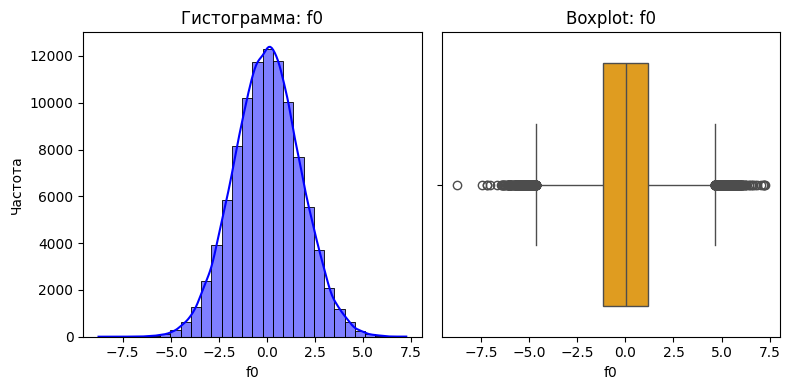


Непрерывный признак: f1


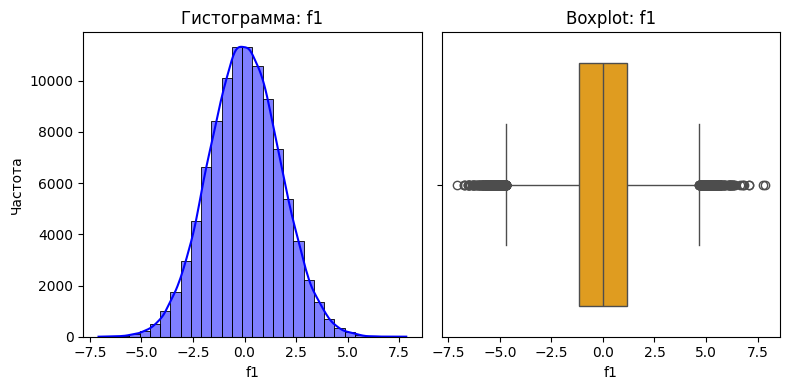


Непрерывный признак: f2


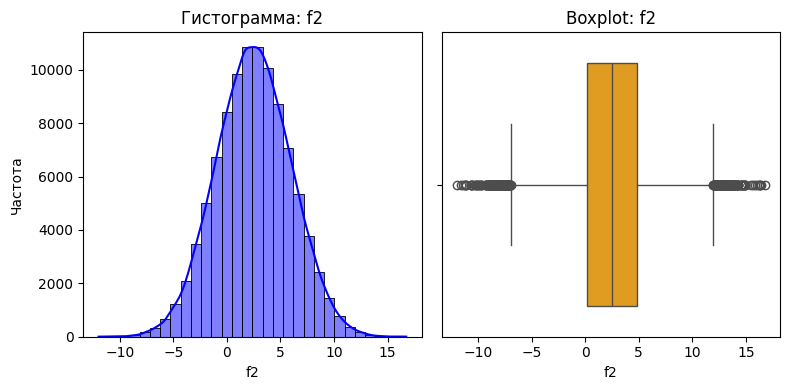


Непрерывный признак: product


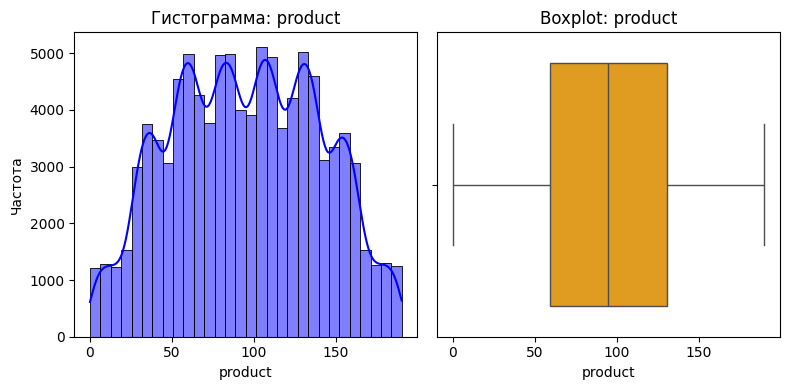

In [19]:
#построим гисторграммы и боксплот для всех числовых полей и столбчатую диаграмму для всех категориальных
plot_eda(geo_data_2)

In [20]:
# вывдем статистическую информацию по числовым полям
geo_data_2.describe()

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.002023,-0.002081,2.495128,95.000000
std,1.732045,1.730417,3.473445,44.749921
min,-8.760004,-7.084020,-11.970335,0.000000
25%,-1.162288,-1.174820,0.130359,59.450441
50%,0.009424,-0.009482,2.484236,94.925613
75%,1.158535,1.163678,4.858794,130.595027
max,7.238262,7.844801,16.739402,190.029838


Вывод:\
Признак f0 распределен нормально, медиана равна 0.01\
Признак f1 распределен нормально, медиана равна -0.01\
Признак f2 распределен нормально, близко к дискретному, медиана равна 2.48\
Параметр product распределен ненормально, медиана равна 94.93

## Общий вывод

Локация №0:\
Признак f0 распределен ненормально, медиана равна 0.50\
Признак f1 распределен ненормально, медиана равна 0.25\
Признак f2 распределен нормально, медиана равна 2.51\
Параметр product распределен ненормально, медиана равна 91.85

Локация №1:\
Признак f0 распределен ненормально, медиана равна 1.15\
Признак f1 распределен нормально, медиана равна -4.81\
Признак f2 распределен ненормально, близко к дискретному, медиана равна 2.01\
Параметр product имеет несколько дискретных значений, медиана равна 57.08

Локация №2:\
Признак f0 распределен нормально, медиана равна 0.01\
Признак f1 распределен нормально, медиана равна -0.01\
Признак f2 распределен нормально, близко к дискретному, медиана равна 2.48\
Параметр product распределен ненормально, медиана равна 94.93

# Корреляционный анализ признаков

In [21]:
def custom_plot_correlation_matrix(df, method='pearson', figsize=(10, 8), annot=True):
    # Исключаем столбцы, содержащие 'id'
    filtered_df = df[[col for col in df.columns if 'id' not in col.lower()]]
    # Выбираем только числовые признаки
    numeric_df = filtered_df.select_dtypes(include=['number'])
    
    # Проверяем, есть ли числовые признаки
    if numeric_df.empty:
        print("В DataFrame нет числовых признаков.")
        return
    
    # Расчёт матрицы корреляций
    correlation_matrix = numeric_df.corr(method=method)
    
    # Построение тепловой карты
    plt.figure(figsize=figsize)
    sns.heatmap(correlation_matrix, annot=annot, fmt='.2f', cmap='coolwarm', cbar=True)
    plt.title(f'Матрица корреляций ({method})')
    plt.show()

## Локация №0

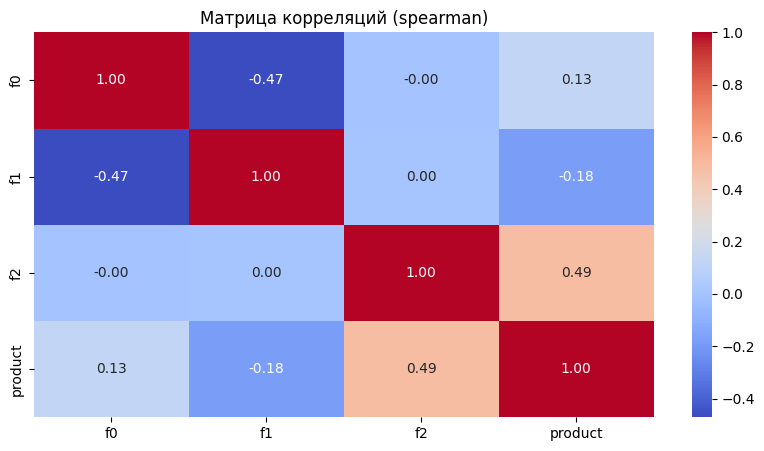

In [22]:
# т.к. данные распределены ненормально, то используем метод Спирмана
custom_plot_correlation_matrix(geo_data_0, method='spearman', figsize=(10, 5), annot=True)

Вывод:\
Наблюдается достаточно сильная корреляция между целевым признаком и признаком f2, также имеется достаточно сильная корреляция между признаками f0 и f1.

## Локация №1

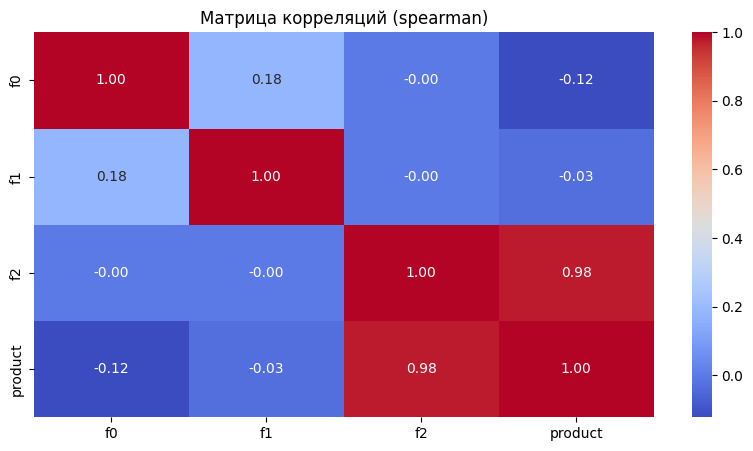

In [23]:
custom_plot_correlation_matrix(geo_data_1, method='spearman', figsize=(10, 5), annot=True)

Вывод:\
Наблюдается очень сильная корреляция (практически 100%) между признаком f2 и целевым признаком, между остальными признаками корреляция слабая. 

## Локация №2

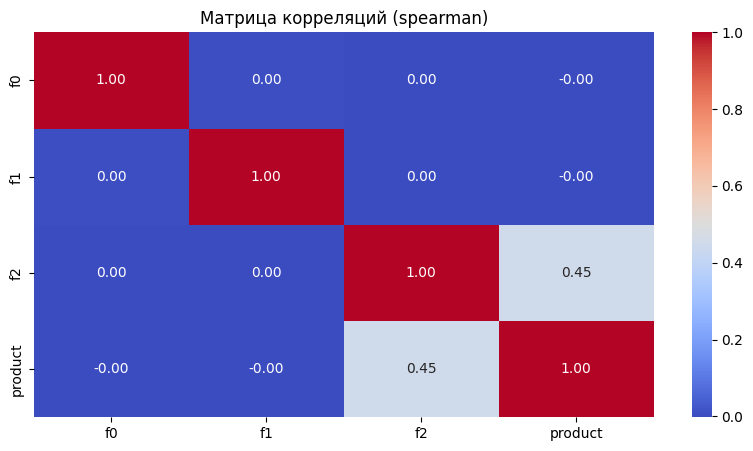

In [24]:
custom_plot_correlation_matrix(geo_data_2, method='spearman', figsize=(10, 5), annot=True)

Вывод:\
Наблюдается очень сильная корреляция между признаком f2 и целевым признаком, между остальными признаками корреляция слабая. 

## Общий вывод

Локация №0:\
Наблюдается достаточно сильная корреляция между целевым признаком и признаком f2, также имеется достаточно сильная корреляция между признаками f0 и f1.

Локация №1:\
Наблюдается очень сильная корреляция (практически 100%) между признаком f2 и целевым признаком, между остальными признаками корреляция слабая. 

Локация №2:\
Наблюдается очень сильная корреляция между признаком f2 и целевым признаком, между остальными признаками корреляция слабая. 

# Моделирование

По условию задачи для прогнозирования подходит только модель линейной регрессии, остальные модели недостаточно предсказуемые. Зададим функции для моделирования. 

## Функции для рассчетов

In [25]:
def model_performance(df, target_column, test_size=0.25, random_state=42):
    # Разделение данных на X и y
    X = df.drop(target_column, axis=1)
    y = df[target_column]

    # Разделение на обучающую и тестовую выборки
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state
    )
    
    # Исключаем столбцы, содержащие 'id'
    filtered_df = X_train[[col for col in X_train.columns if 'id' not in col.lower()]]

    # Определяем числовые и категориальные столбцы
    num_col_names = filtered_df.select_dtypes(include=['number']).columns
    cat_col_names = filtered_df.select_dtypes(exclude=['number']).columns

    # Кодирование категориальных признаков
    encoder = OneHotEncoder(drop='first', sparse_output=False)
    X_train_ohe = encoder.fit_transform(X_train[cat_col_names])
    X_test_ohe = encoder.transform(X_test[cat_col_names])
    encoder_col_names = encoder.get_feature_names_out(cat_col_names)

    # Масштабирование числовых признаков
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train[num_col_names])
    X_test_scaled = scaler.transform(X_test[num_col_names])

    # Преобразование в DataFrame
    X_train_ohe = pd.DataFrame(X_train_ohe, columns=encoder_col_names, index=X_train.index)
    X_test_ohe = pd.DataFrame(X_test_ohe, columns=encoder_col_names, index=X_test.index)
    X_train_scaled = pd.DataFrame(X_train_scaled, columns=num_col_names, index=X_train.index)
    X_test_scaled = pd.DataFrame(X_test_scaled, columns=num_col_names, index=X_test.index)

    # Объединение обработанных данных
    X_train_prepared = pd.concat([X_train_ohe, X_train_scaled], axis=1)
    X_test_prepared = pd.concat([X_test_ohe, X_test_scaled], axis=1)

    # Обучение модели
    model = LinearRegression()
    model.fit(X_train_prepared, y_train)
    predictions = model.predict(X_test_prepared)

    # Вычисление остатков
    residuals = y_test - predictions

    # Список всех признаков
    feature_names = X_train_prepared.columns.tolist()

    return model, encoder, scaler, residuals, predictions, feature_names, X_test, y_test

In [26]:
def plot_errors(predictions, residuals):
    # Построение графиков остатков
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
    axes[0].hist(residuals)
    axes[0].set_title('Гистограмма распределения остатков')
    axes[0].set_xlabel('Остатки')
    
    axes[1].scatter(x=predictions, y=residuals)
    axes[1].set_xlabel('Предсказания модели')
    axes[1].set_ylabel('Остатки')
    axes[1].set_title('Анализ дисперсии')
    
    plt.tight_layout()
    plt.show()

In [27]:
def calculate_metrics(y_true, predictions, confidence=0.95):
    # Рассчёт метрик
    r2 = r2_score(y_true, predictions)
    mae = mean_absolute_error(y_true, predictions)
    mse = mean_squared_error(y_true, predictions)
    rmse = np.sqrt(mse)

    # Доверительный интервал для ошибок (по квантилям)
    alpha = 1 - confidence
    lower_quantile = np.quantile(residuals, alpha / 2)
    upper_quantile = np.quantile(residuals, 1 - alpha / 2)
    ci_lower = round(lower_quantile, 2)
    ci_upper = round(upper_quantile, 2)

    metrics = {
        'R2': r2,
        'MAE': mae,
        'MSE': mse,
        'RMSE': rmse,
        'Error_CI': (ci_lower, ci_upper)
    }
    print(metrics)
    
    return metrics

In [28]:
def get_feature_importance(model, feature_names):
    # Получение коэффициентов модели
    coefficients = model.coef_
    
    # Создание DataFrame
    feature_importance = pd.DataFrame({
        'feature': feature_names,
        'importance': coefficients
    })
    
    # Сортировка по абсолютному значению коэффициентов
    feature_importance['abs_importance'] = feature_importance['importance'].abs()
    feature_importance = feature_importance.sort_values(by='abs_importance', ascending=False)
    
    display(feature_importance[['feature', 'importance']])

In [29]:
def get_model_quality(df, model, residuals, predictions, feature_names, confidence=0.95):
    # функция для построения графиков остатков
    plot_errors(predictions, residuals)
    
    y_true = residuals + predictions
    print('Метрики модели:')
    # функция для вывода метрик
    calculate_metrics(y_true, predictions, confidence=confidence)

    feature_names = feature_names
    print('Анализ важности признаков:')
    # функция для анализа важности признаков
    get_feature_importance(model, feature_names)

## Модель. Локация №0

In [30]:
# применим функцию для обучения модели
model, encoder, scaler, residuals, predictions, feature_names, X_test, y_test = model_performance(geo_data_0, target_column='product')

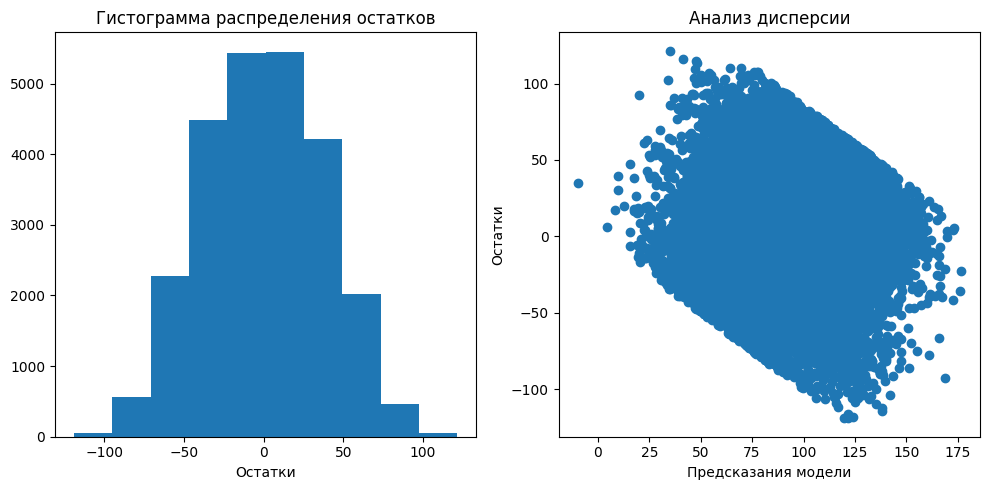

Метрики модели:
{'R2': 0.2728287328173471, 'MAE': 31.04768153878818, 'MSE': 1425.5608700093812, 'RMSE': 37.75660035026169, 'Error_CI': (-70.69, 70.61)}
Анализ важности признаков:


,feature,importance
2,f2,21.423950
1,f1,-7.181963
0,f0,3.342676


In [31]:
get_model_quality(geo_data_0, model, residuals, predictions, feature_names)

In [32]:
predictions.mean()

92.39879990657768

In [33]:
val_geo_0 = pd.concat([X_test.reset_index(drop=True), pd.DataFrame(y_test).reset_index(drop=True)], axis=1)
val_geo_0 = pd.concat([val_geo_0, pd.DataFrame(predictions)], axis=1)
val_geo_0 = val_geo_0.rename(columns={0:'preds'})

In [34]:
val_geo_0.head()

,id,f0,f1,f2,product,preds
0,7C6bA,0.599283,-0.557623,2.121187,122.073350,101.901017
1,dVxsn,0.739017,-0.463156,-1.347584,48.738540,78.217774
2,1Gm3l,1.422743,-0.534917,3.718798,131.338088,115.266901
3,Nzg1t,1.580244,-0.238458,2.805149,88.327757,105.618618
4,Z7b4F,0.918974,0.023961,2.598575,36.959266,97.980185


In [35]:
val_geo_0['preds'].mean()

92.39879990657768

Вывод:\
Распределение остатков похоже на нормальное, однако, дисперсия распределена неравномерно.\
'RMSE': 37.76\
Среднее предсказанное значение объема продукта в скважине 92.4

## Модель. Локация №1

In [36]:
# применим функцию для обучения модели
model, encoder, scaler, residuals, predictions, feature_names, X_test, y_test = model_performance(geo_data_1, target_column='product')

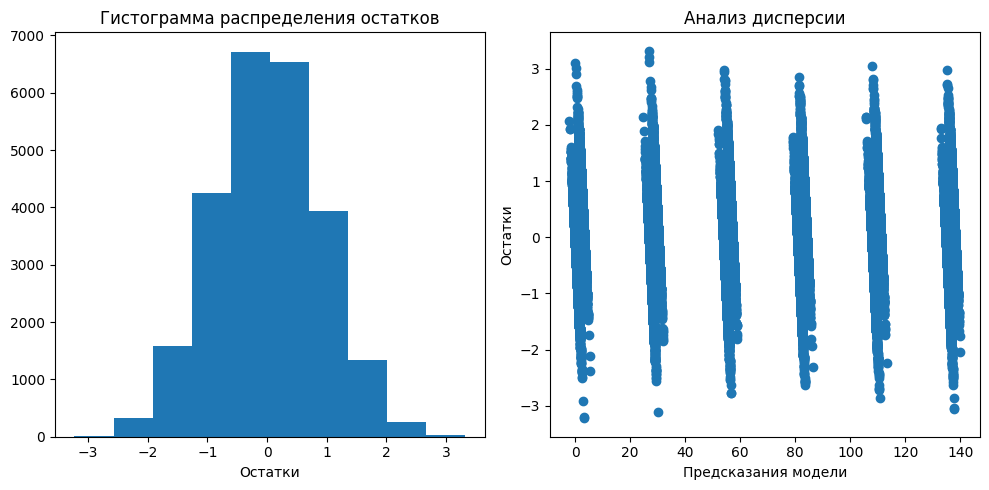

Метрики модели:
{'R2': 0.9996245232002449, 'MAE': 0.717011953568255, 'MSE': 0.7925986566392008, 'RMSE': 0.8902801001028838, 'Error_CI': (-1.71, 1.74)}
Анализ важности признаков:


,feature,importance
2,f2,45.913330
0,f0,-1.298956
1,f1,-0.110911


In [37]:
get_model_quality(geo_data_1, model, residuals, predictions, feature_names)

In [38]:
predictions.mean()

68.7128780391376

In [39]:
val_geo_1 = pd.concat([X_test.reset_index(drop=True), pd.DataFrame(y_test).reset_index(drop=True)], axis=1)
val_geo_1 = pd.concat([val_geo_1, pd.DataFrame(predictions)], axis=1)
val_geo_1 = val_geo_1.rename(columns={0:'preds'})

In [40]:
val_geo_1.head()

,id,f0,f1,f2,product,preds
0,fYVDK,6.078076,0.084568,0.002957,0.000000,0.844738
1,3SQcq,16.462386,2.712946,1.993030,53.906522,52.921612
2,hQ1gJ,7.051898,0.766983,4.990194,134.766305,135.110385
3,Y4vux,-0.240045,-0.380804,3.999693,107.813044,109.494863
4,H1NUw,13.350111,-8.558281,0.002010,0.000000,-0.047292


In [41]:
val_geo_1['preds'].mean()

68.7128780391376

Вывод:\
Распределение остатков похоже на нормальное, однако, дисперсия распределена равномерно, но дискретно, как и значения целевого признака.\
'RMSE': 0.89\
Среднее предсказанное значение объема продукта в скважине 68.71

## Модель. Локация №2

In [42]:
# применим функцию для обучения модели
model, encoder, scaler, residuals, predictions, feature_names, X_test, y_test = model_performance(geo_data_2, target_column='product')

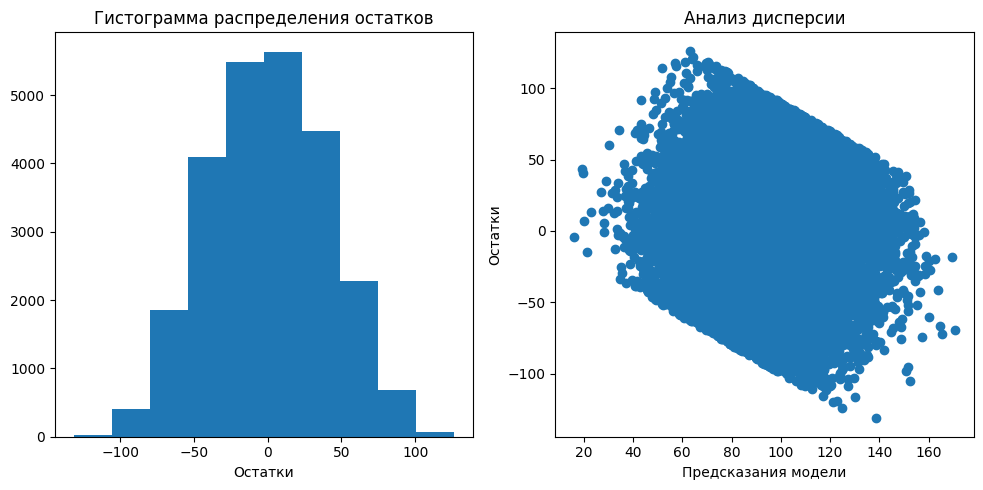

Метрики модели:
{'R2': 0.19634705977280464, 'MAE': 32.89695861057806, 'MSE': 1611.6910636385905, 'RMSE': 40.14587231134218, 'Error_CI': (-75.14, 77.76)}
Анализ важности признаков:


,feature,importance
2,f2,19.987916
0,f0,-0.145676
1,f1,-0.026776


In [43]:
get_model_quality(geo_data_2, model, residuals, predictions, feature_names)

In [44]:
predictions.mean()

94.77102387765939

In [45]:
val_geo_2 = pd.concat([X_test.reset_index(drop=True), pd.DataFrame(y_test).reset_index(drop=True)], axis=1)
val_geo_2 = pd.concat([val_geo_2, pd.DataFrame(predictions)], axis=1)
val_geo_2 = val_geo_2.rename(columns={0:'preds'})

In [46]:
val_geo_2.head()

,id,f0,f1,f2,product,preds
0,sPjbT,2.111118,-1.679773,3.112240,117.441301,98.301916
1,1u4uo,0.734759,0.747788,3.670879,47.841249,101.592461
2,kZ6HO,-2.513109,0.844631,-4.922889,45.883483,52.449099
3,gCZGK,-2.035301,-1.522988,5.072839,139.014608,109.922127
4,rqJHx,2.744145,1.429952,-1.372661,84.004276,72.411847


In [47]:
val_geo_2['preds'].mean()

94.77102387765939

Вывод:\
Распределение остатков похоже на нормальное, однако, дисперсия распределена неравномерно.\
'RMSE': 40.15\
Среднее предсказанное значение объема продукта в скважине 94.77

## Общий вывод

Модель по локации №0:\
Распределение остатков похоже на нормальное, однако, дисперсия распределена неравномерно.\
'RMSE': 37.76\
Все метрики модели:\
{'R2': 0.2728287328173471, 'MAE': 31.04768153878818, 'MSE': 1425.5608700093812, 'RMSE': 37.75660035026169, 'Error_CI': (-70.69, 70.61)}\
Среднее предсказанное значение объема продукта в скважине 92.4

Модель по локации №1:\
Распределение остатков похоже на нормальное, однако, дисперсия распределена равномерно, но дискретно, как и значения целевого признака.\
'RMSE': 0.89\
Все метрики модели:\
{'R2': 0.9996245232002449, 'MAE': 0.717011953568255, 'MSE': 0.7925986566392008, 'RMSE': 0.8902801001028838, 'Error_CI': (-1.71, 1.74)}\
Среднее предсказанное значение объема продукта в скважине 68.71

Модель по локации №2:\
Распределение остатков похоже на нормальное, однако, дисперсия распределена неравномерно.\
'RMSE': 40.15\
Все метрики модели:\
{'R2': 0.19634705977280464, 'MAE': 32.89695861057806, 'MSE': 1611.6910636385905, 'RMSE': 40.14587231134218, 'Error_CI': (-75.14, 77.76)}\
Среднее предсказанное значение объема продукта в скважине 94.77

Качество модели по локации №1 выглядит наиболее оптимальным, однако, в данной локации ниизкое среднее значение продукта.

# Подготовка к расчету прибыли

In [48]:
POINTS_FOR_RESEARCH = 700
BEST_POINTS = 200
BUDGET = 20_000_000_000
PRICE_PER_BARREL = 450
REVENUE_ONE_PRODUCT = 450_000

In [49]:
n = 1
revenue = REVENUE_ONE_PRODUCT * n
while revenue < BUDGET:
    n += 1
    revenue = REVENUE_ONE_PRODUCT * n 

print(f"Суммарный объем продукта: {n}")
print(f"Общий доход: {revenue}")
print(f"Объем продукта на скважину: {n/BEST_POINTS}")

Суммарный объем продукта: 22223
Общий доход: 10000350000
Объем продукта на скважину: 111.115


Вывод:\
Для получения безубыточности разработки локации необходимо получить следующие параметры:\
Суммарный объем продукта: ~22223\
Средний объем продукта на скважину: ~111.115

Текущее среднее предсказанное значение ниже данных показателей, однако, оно посчитано по всем скважинам, а не по лучшим. 

# Расчет потенциальной прибыли по скважинам

In [50]:
# создадим функцию для рассчета прибыли
def calculate_wells_revenue(data, target_column = 'preds'):
    global n, BEST_POINTS, REVENUE_ONE_PRODUCT, BUDGET
    data2 = data.sort_values(by=target_column, ascending=False).iloc[:BEST_POINTS]
    product_best = round(data2['product'].sum(), 2)
    product_mean = round(data2['product'].mean(), 2)

    if product_best >= n:
        print(f'Общий объем продукта больше или равен целевому и составляет: {product_best}')
    else:
        print(f'Общий объем продукта меньше целевого и составляет: {product_best}')


    if product_mean >= n/BEST_POINTS:
        print(f'Средний объем продукта на скважину больше или равен целевому и составляет: {product_mean}')
    else:
        print(f'Средний объем продукта на скважину меньше целевого и составляет: {product_mean}')

    income = product_best*REVENUE_ONE_PRODUCT - BUDGET
    print(f'Возможная прибыль (выручка за минусом бюджета разработки) в данной локации составляет: {income}')

    return data2, product_best, product_mean, income

Локация №0:

In [51]:
top_geo_0, product_best_0, product_mean_0, income_0 = calculate_wells_revenue(val_geo_0)

Общий объем продукта больше или равен целевому и составляет: 29686.98
Средний объем продукта на скважину больше или равен целевому и составляет: 148.43
Возможная прибыль (выручка за минусом бюджета разработки) в данной локации составляет: 3359141000.0


Локация №1:

In [52]:
top_geo_1, product_best_1, product_mean_1, income_1 = calculate_wells_revenue(val_geo_1)

Общий объем продукта больше или равен целевому и составляет: 27589.08
Средний объем продукта на скважину больше или равен целевому и составляет: 137.95
Возможная прибыль (выручка за минусом бюджета разработки) в данной локации составляет: 2415086000.0


Локация №2:

In [53]:
top_geo_2, product_best_2, product_mean_2, income_2 = calculate_wells_revenue(val_geo_2)

Общий объем продукта больше или равен целевому и составляет: 27996.83
Средний объем продукта на скважину больше или равен целевому и составляет: 139.98
Возможная прибыль (выручка за минусом бюджета разработки) в данной локации составляет: 2598573500.0


Вывод:\
Наибольшую потенциальную прибыль по данным предварительных рассчетов может принести локация №0, меньше всего локация №1. Все локации преодолели порог безубыточности. 

# Расчет рисков

In [54]:
def bootstrap_profit(data, target_column = 'preds', n_bootstrap = 1000):
    global BEST_POINTS, REVENUE_ONE_PRODUCT, BUDGET, POINTS_FOR_RESEARCH
    
    state = np.random.RandomState(12345)
    profits = []
    
    for i in range(n_bootstrap):
        # Сэмплируем фрагмент данных с повторением (по всей выборке)
        sample = data.sample(n=POINTS_FOR_RESEARCH, replace=True, random_state=state)
        
        top_sample = sample.sort_values(by=target_column, ascending=False).iloc[:BEST_POINTS]
        
        # Суммарный объём продукта
        total_product = top_sample['product'].sum()
        
        # Вычисляем прибыль
        profit = total_product * REVENUE_ONE_PRODUCT - BUDGET
        
        profits.append(profit)
    
    profits = pd.Series(profits)
    
    # Средняя прибыль
    mean_profit = profits.mean()
    
    # Доверительный интервал (2.5% и 97.5%)
    lower = profits.quantile(0.025)
    upper = profits.quantile(0.975)
    conf_interval = (lower, upper)
    
    # Риск убытков (доля отрицательных прибылей)
    loss_risk = (profits < 0).mean()
    
    return mean_profit, conf_interval, loss_risk

In [55]:
mean_profit_0, conf_int_0, risk_0 = bootstrap_profit(val_geo_0, target_column='preds')
mean_profit_1, conf_int_1, risk_1 = bootstrap_profit(val_geo_1, target_column='preds')
mean_profit_2, conf_int_2, risk_2 = bootstrap_profit(val_geo_2, target_column='preds')

print('Локация №0')
print(f'Средняя прибыль: {mean_profit_0:.2f}')
print(f'95%-й доверительный интервал: [{conf_int_0[0]:.2f}, {conf_int_0[1]:.2f}]')
print(f'Риск убытков: {risk_0:.2%}')

print('\nЛокация №1')
print(f'Средняя прибыль: {mean_profit_1:.2f}')
print(f'95%-й доверительный интервал: [{conf_int_1[0]:.2f}, {conf_int_1[1]:.2f}]')
print(f'Риск убытков: {risk_1:.2%}')

print('\nЛокация №2')
print(f'Средняя прибыль: {mean_profit_2:.2f}')
print(f'95%-й доверительный интервал: [{conf_int_2[0]:.2f}, {conf_int_2[1]:.2f}]')
print(f'Риск убытков: {risk_2:.2%}')

Локация №0
Средняя прибыль: 406278783.42
95%-й доверительный интервал: [-117742136.49, 911737050.75]
Риск убытков: 6.70%

Локация №1
Средняя прибыль: 432624131.81
95%-й доверительный интервал: [16846174.93, 815972526.29]
Риск убытков: 1.90%

Локация №2
Средняя прибыль: 377362192.42
95%-й доверительный интервал: [-170780417.71, 901772131.39]
Риск убытков: 7.40%


Вывод:\
По результам расчета наибольшая средняя прибыль возможна в локации №1 и составляет 432 624 131р., 95%-й доверительный интервал: [16846174.93, 815972526.29], кроме того, только в данной локации риск убытков ниже заданного порога и составляет 1,9%.

# Общий вывод по проекту

**Задача:**\
В рамках выполнения данного проекта решалась задача выбора наилучшей локации для разработки новых скважин по добыче нефти. 

**Исходные данные:**\
Были предоставлены исходные данные, которые состояли из 3х таблиц с синтетическими данными, отражающими характеристики скважин. 

**Предобработка данных:**\
Был выполнен обзор и предобработка данных. 

**Подбор модели:**\
По условияю задачи для выполнения предсказаний следовало использовать только модель линейной регрессии, т.к. другие модели недостаточно информативные. 
При моделировании получились следующие характеристики моделей:
Модель по локации №0:\
Распределение остатков похоже на нормальное, однако, дисперсия распределена неравномерно.\
'RMSE': 37.76\
Все метрики модели:\
{'R2': 0.2728287328173471, 'MAE': 31.04768153878818, 'MSE': 1425.5608700093812, 'RMSE': 37.75660035026169, 'Error_CI': (-70.69, 70.61)}\
Среднее предсказанное значение объема продукта в скважине 92.4

Модель по локации №1:\
Распределение остатков похоже на нормальное, однако, дисперсия распределена равномерно, но дискретно, как и значения целевого признака.\
'RMSE': 0.89\
Все метрики модели:\
{'R2': 0.9996245232002449, 'MAE': 0.717011953568255, 'MSE': 0.7925986566392008, 'RMSE': 0.8902801001028838, 'Error_CI': (-1.71, 1.74)}\
Среднее предсказанное значение объема продукта в скважине 68.71

Модель по локации №2:\
Распределение остатков похоже на нормальное, однако, дисперсия распределена неравномерно.\
'RMSE': 40.15\
Все метрики модели:\
{'R2': 0.19634705977280464, 'MAE': 32.89695861057806, 'MSE': 1611.6910636385905, 'RMSE': 40.14587231134218, 'Error_CI': (-75.14, 77.76)}\
Среднее предсказанное значение объема продукта в скважине 94.77

Для получения безубыточности разработки локации необходимо получить следующие параметры:\
Суммарный объем продукта: ~22223\
Средний объем продукта на скважину: ~111.115

**Результаты расчета риска и потенциальной прибыли:**\
Локация №0\
Средняя прибыль: 406278783.42\
95%-й доверительный интервал: [-117742136.49, 911737050.75]\
Риск убытков: 6.70%

Локация №1\
Средняя прибыль: 432624131.81\
95%-й доверительный интервал: [16846174.93, 815972526.29]\
Риск убытков: 1.90%

Локация №2\
Средняя прибыль: 377362192.42\
95%-й доверительный интервал: [-170780417.71, 901772131.39]\
Риск убытков: 7.40%


**Рекомендации и предложения для бизнеса:**\
На основании полученных результатов рекомендуется принять к разработке локацию №1, т.к. она обладает наибольшим потенциалом прибыли и риск убытков ниже заявленного порога. 